# Imports

In [24]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import wave
#import pyaudio
import numpy as np
import sounddevice as sd
import cv2
from scipy.signal import iirnotch, filtfilt
from glob import glob
from tqdm import tqdm

# Load Data

In [25]:
sub_files = glob('../*/*.xdf')
sub_files

['../sub-P5318014/sub-P5318014_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-5182010/sub-P5182010_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-P5447527/sub-P5447527_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-5958030/sub-P5958030_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-P5548165/sub-P5548165_ses-S001_task-CUNY_run-001_MOBI.xdf']

In [26]:
xdf_path = sub_files[3]
data, header = pyxdf.load_xdf(xdf_path)
streams_collected = [stream['info']['name'][0] for stream in data]


'''
HELPERS
'''
def get_event_data(event, df, stim_df):
    return df.loc[(df.lsl_time_stamp >= stim_df.loc[stim_df.event == 'Onset_'+event, 'lsl_time_stamp'].values[0]) & 
                  (df.lsl_time_stamp <= stim_df.loc[stim_df.event == 'Offset_'+event, 'lsl_time_stamp'].values[0])]

def get_secs_between_triggers(trigger1, trigger2, stim_df):
    return stim_df.loc[stim_df.trigger == trigger1, 'time'].values[0] - stim_df.loc[stim_df.trigger == trigger2, 'time'].values[0]

                  
streams_collected

['WebcamStream',
 'Tobii',
 'OpenSignals',
 'EGI NetAmp 0',
 'Stimuli_Markers',
 'Microphone']

# Stimulus

In [27]:
stim_dat = data[streams_collected.index('Stimuli_Markers')]
stim_df = pd.DataFrame(stim_dat['time_series'])
stim_df.rename(columns={0: 'trigger'}, inplace=True)
events = {
    200: 'Onset_Experiment',
    10: 'Onset_RestingState',
    11: 'Offset_RestingState',
    500: 'Onset_StoryListening',
    501: 'Offset_StoryListening',
    100: 'Onset_10second_rest',
    101: 'Offset_10second_rest', 
    20: 'Onset_CampFriend',
    21: 'Offset_CampFriend',
    30: 'Onset_FrogDissection',
    31: 'Offset_FrogDissection',
    40: 'Onset_DanceContest',
    41: 'Offset_DanceContest',
    50: 'Onset_ZoomClass',
    51: 'Offset_ZoomClass',
    60: 'Onset_Tornado',
    61: 'Offset_Tornado',
    70: 'Onset_BirthdayParty',
    71: 'Offset_BirthdayParty',
    300: 'Onset_subjectInput',
    301: 'Offset_subjectInput',
    302: 'Onset_FavoriteStory',
    303: 'Offset_FavoriteStory',
    304: 'Onset_WorstStory',
    305: 'Offset_WorstStory',
    400: 'Onset_impedanceCheck',
    401: 'Offset_impedanceCheck',
    80: 'Onset_SocialTask',
    81: 'Offset_SocialTask',
    201: 'Offset_Experiment',
}

story_onsets = [20, 30, 40, 50, 60, 70]

# relabel the event if the trigger is in the events dictionary, else if 
stim_df['event'] = stim_df['trigger'].apply(lambda x: events[x] if x in events.keys() else 'Bx_input')

# relabel the event as a psychopy timestamp if the trigger is greater than 5 digits
stim_df.loc[stim_df.trigger.astype(str).str.len() > 5, 'event'] = 'psychopy_time_stamp'
stim_df['lsl_time_stamp'] = stim_dat['time_stamps']
stim_df['time'] = (stim_dat['time_stamps'] - stim_dat['time_stamps'][0])/1000
stim_df

,trigger,event,lsl_time_stamp,time
0,2.000000e+02,Onset_Experiment,1.073920e+06,0.000000e+00
1,1.735058e+09,psychopy_time_stamp,1.073920e+06,9.799609e-09
2,1.000000e+01,Onset_RestingState,1.073940e+06,1.976684e-02
3,1.735058e+09,psychopy_time_stamp,1.073940e+06,1.976685e-02
4,1.100000e+01,Offset_RestingState,1.074240e+06,3.197662e-01
...,...,...,...,...
256,1.735060e+09,psychopy_time_stamp,1.076101e+06,2.180627e+00
257,2.010000e+02,Offset_Experiment,1.076106e+06,2.185632e+00
258,1.735060e+09,psychopy_time_stamp,1.076106e+06,2.185632e+00
259,4.000000e+00,Bx_input,1.076106e+06,2.185633e+00


In [28]:
stim_dat['time_stamps'][-1]-stim_dat['time_stamps'][0]

2185.6325409545098

In [29]:
stim_df[stim_df['event'].isin(events.values())]

,trigger,event,lsl_time_stamp,time
0,200.0,Onset_Experiment,1.073920e+06,0.000000
2,10.0,Onset_RestingState,1.073940e+06,0.019767
4,11.0,Offset_RestingState,1.074240e+06,0.319766
6,500.0,Onset_StoryListening,1.074240e+06,0.319766
8,100.0,Onset_10second_rest,1.074269e+06,0.348517
...,...,...,...,...
249,400.0,Onset_impedanceCheck,1.075425e+06,1.504750
251,401.0,Offset_impedanceCheck,1.075768e+06,1.847668
253,80.0,Onset_SocialTask,1.075800e+06,1.880134
255,81.0,Offset_SocialTask,1.076101e+06,2.180627


## Compare time between Onset/ Offset event triggers and the stimulus durations

In [30]:
# audio_recordings= [
#     "../audio_files/audio_files/After_Searching_I_Found_and_Met_My_Birth_Mother.wav",
#     "../audio_files/audio_files/Camp_Lose_A_Friend.wav",
#     "../audio_files/audio_files/Frog_Dissection_Disaster.wav",
#     "../audio_files/audio_files/I_Decided_To_Be_Myself_And_Won_A_Dance_Contest.wav",
#     "../audio_files/audio_files/I_Fully_Embarrassed_Myself_In_Zoom_Class1.wav",
#     "../audio_files/audio_files/Left_Home_Alone_in_a_Tornado.wav",
#     "../audio_files/audio_files/The_Birthday_Party_Prank.wav",
#     "../audio_files/audio_files/My_Dad_Saw_Me_Wearing_Glitter_At_School.wav"
# ]

durations = pd.DataFrame({
    'trigger':story_onsets,
    'story':[events[x] for x in story_onsets],
    'lsl_duration': [get_secs_between_triggers(x+1, x, stim_df) for x in story_onsets],
    # 'audiofile_duration': [wave.open(x).getnframes()/wave.open(x).getframerate() for x in audio_recordings] #duration of audio file is number of frames divided by the frame rate.
})

# durations['difference(sec)'] = durations['audiofile_duration'] - durations['lsl_duration']
durations

,trigger,story,lsl_duration
0,20,Onset_CampFriend,0.140440
1,30,Onset_FrogDissection,0.114259
2,40,Onset_DanceContest,0.127104
3,50,Onset_ZoomClass,0.090379
4,60,Onset_Tornado,0.149979
5,70,Onset_BirthdayParty,0.147214


# Making sure durations are correct for each stream

In [31]:
exp_start = stim_df.loc[stim_df.event == 'Onset_Experiment', 'lsl_time_stamp'].values[0]
exp_end = stim_df.loc[stim_df.event == 'Offset_Experiment', 'lsl_time_stamp'].values[0]
exp_dur = exp_end - exp_start
exp_dur


2185.632318155607

In [32]:
ET = data[streams_collected.index('Tobii')]
et_dat = ET['time_series']
# Get the column names
column_labels = [ET['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(ET['info']['desc'][0]['channels'][0]['channel']))]

et_df = pd.DataFrame(data=et_dat, columns=column_labels)
et_df['lsl_time_stamp'] = ET['time_stamps']
et_df['time'] = (ET['time_stamps'] - ET['time_stamps'][0])/1000
et_df.head()

,device_time_stamp,left_gaze_origin_validity,right_gaze_origin_validity,left_gaze_origin_in_user_coordinate_system_0,left_gaze_origin_in_user_coordinate_system_1,left_gaze_origin_in_user_coordinate_system_2,right_gaze_origin_in_user_coordinate_system_0,right_gaze_origin_in_user_coordinate_system_1,right_gaze_origin_in_user_coordinate_system_2,left_gaze_origin_in_trackbox_coordinate_system_0,...,left_gaze_point_on_display_area_0,left_gaze_point_on_display_area_1,right_gaze_point_on_display_area_0,right_gaze_point_on_display_area_1,left_pupil_validity,right_pupil_validity,left_pupil_diameter,right_pupil_diameter,lsl_time_stamp,time
0,2.062699e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,1.073920e+06,0.000000
1,2.062699e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,1.073921e+06,0.000008
2,2.062699e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,1.073921e+06,0.000017
3,2.062699e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,1.073921e+06,0.000025
4,2.062699e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,1.073921e+06,0.000033


In [33]:
et_exp = get_event_data('Experiment', et_df, stim_df=stim_df)
start = et_exp['lsl_time_stamp'].values[0]
stop = et_exp['lsl_time_stamp'].values[-1]
et_dur = stop - start
et_dur

2185.277708688285

<Axes: xlabel='time', ylabel='right_pupil_diameter'>

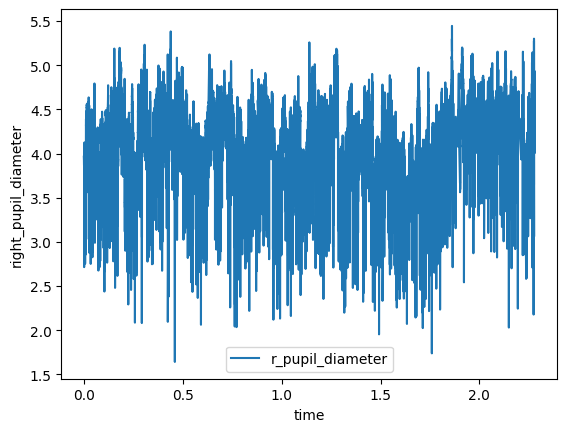

In [34]:
sns.lineplot(data=et_df, x='time', y='right_pupil_diameter', label='r_pupil_diameter')

# Physio

In [35]:
PS = data[streams_collected.index('OpenSignals')]
# Get the column names
column_labels = [PS['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(PS['info']['desc'][0]['channels'][0]['channel']))]
ps_df = pd.DataFrame(data=PS['time_series'], columns=column_labels)
ps_df['lsl_time_stamp'] = PS['time_stamps']
ps_df['time'] = (PS['time_stamps'] - PS['time_stamps'][0])/1000
ps_df

,nSeq,RESPIRATION0,ECG1,EDA2,fSpO23,fSpO24,%SpO25,lsl_time_stamp,time
0,110775.0,-0.02582,1.45963,2.6134,0.55642,1.06794,27.0,1.073908e+06,0.000000
1,110776.0,-0.02637,1.46269,2.6154,0.55640,1.06793,27.0,1.073908e+06,0.000002
2,110777.0,-0.02582,1.45568,2.6161,0.55640,1.06793,27.0,1.073908e+06,0.000004
3,110778.0,-0.02618,1.44463,2.6161,0.55637,1.06789,27.0,1.073908e+06,0.000006
4,110779.0,-0.02582,1.43448,2.6173,0.55631,1.06791,27.0,1.073908e+06,0.000008
...,...,...,...,...,...,...,...,...,...
1176795,1287570.0,-0.01520,-0.34941,7.1915,0.53018,1.08721,22.0,1.076263e+06,2.354392
1176796,1287571.0,-0.01474,-0.27475,7.1899,0.53009,1.08728,22.0,1.076263e+06,2.354394
1176797,1287572.0,-0.01520,-0.21240,7.1884,0.53009,1.08732,22.0,1.076263e+06,2.354396
1176798,1287573.0,-0.01520,-0.15220,7.1899,0.53015,1.08730,22.0,1.076263e+06,2.354398


In [36]:
ps_exp = get_event_data('Experiment', ps_df, stim_df=stim_df)
start = ps_exp['lsl_time_stamp'].values[0]
stop = ps_exp['lsl_time_stamp'].values[-1]
ps_dur = stop - start
ps_dur


2185.630074840039

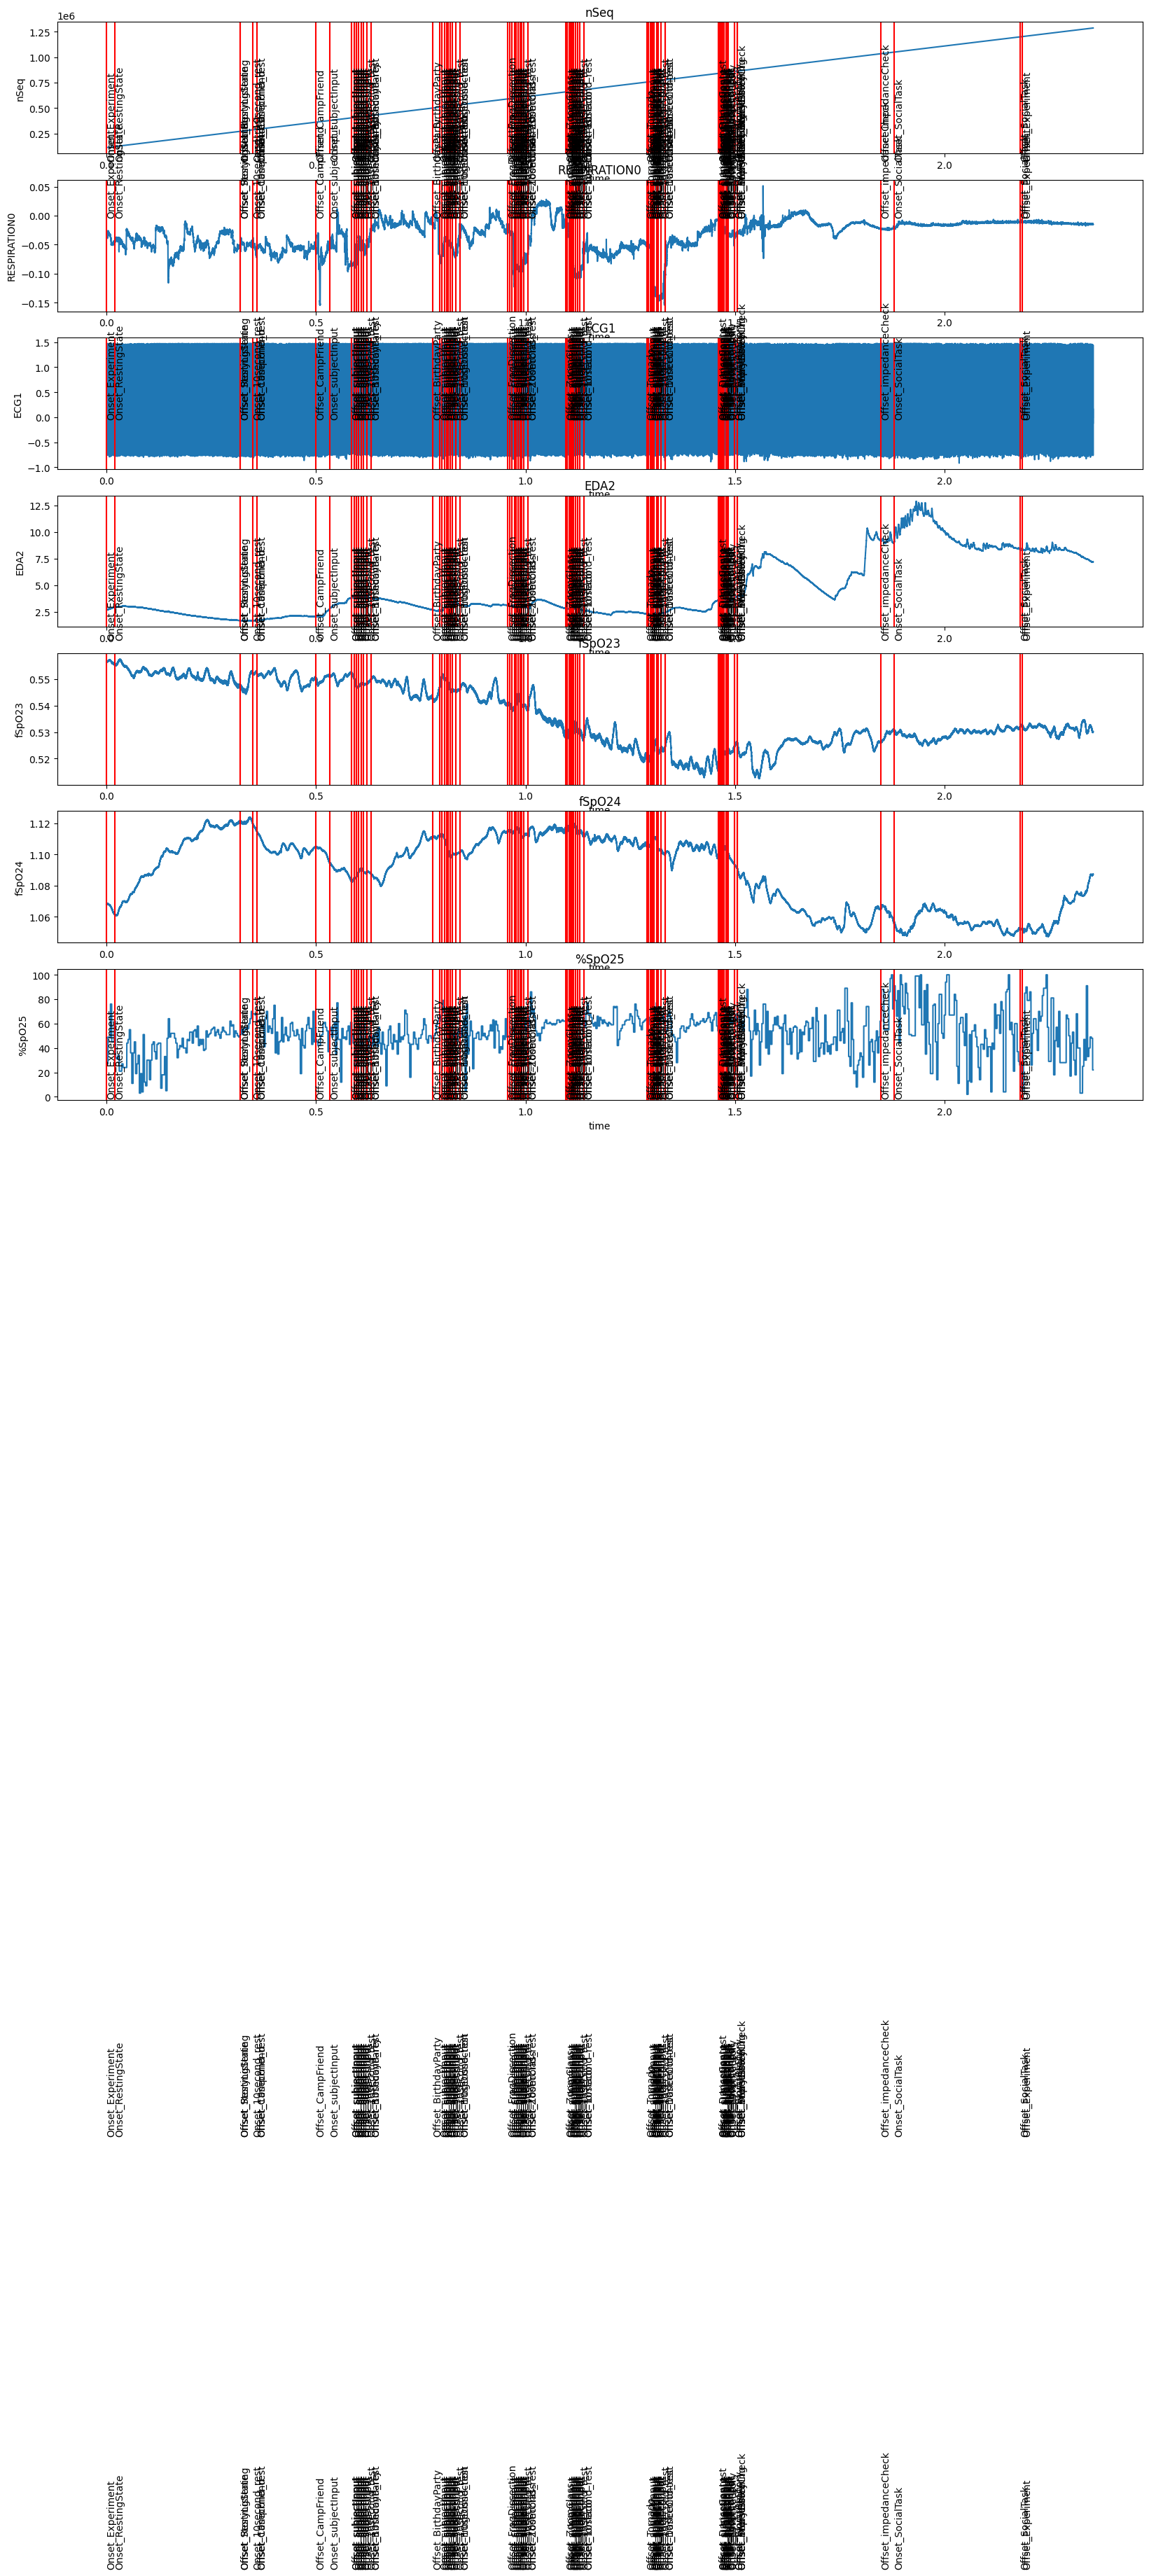

In [37]:
    
'''
# Plot every column in one plot
'''
# confirm all events are in the stim_df
evs = stim_df.loc[stim_df.event != 'psychopy_time_stamp']

f, ax = plt.subplots(figsize=(20,20), nrows=len(column_labels), ncols=1)

# Make this one figure with subplots
for i, col in enumerate(column_labels):
    
    #plt.plot(ps_df.loc[(ps_df['time'] > 1000) & (ps_df['time'] < 1015), col])
    #plt.subplot(ps_df['time'], ps_df[col], ax= ax[i])
    sns.lineplot(data=ps_df, x='time', y=col, ax=ax[i])
    # Place and Vline at every event in evs with onset and offset
    for event in evs.iterrows():
        # If the word Onset or Offset is in the event, plot a vertical line at the time of the event

        if "Onset" in event[1]['event'] or "Offset" in event[1]['event']:
            ax[i].axvline(event[1]['time'], color='r')
            ax[i].text(event[1]['time'], 0, event[1]['event'], rotation=90)
        
    ax[i].set_title(col)
    #plt.show()

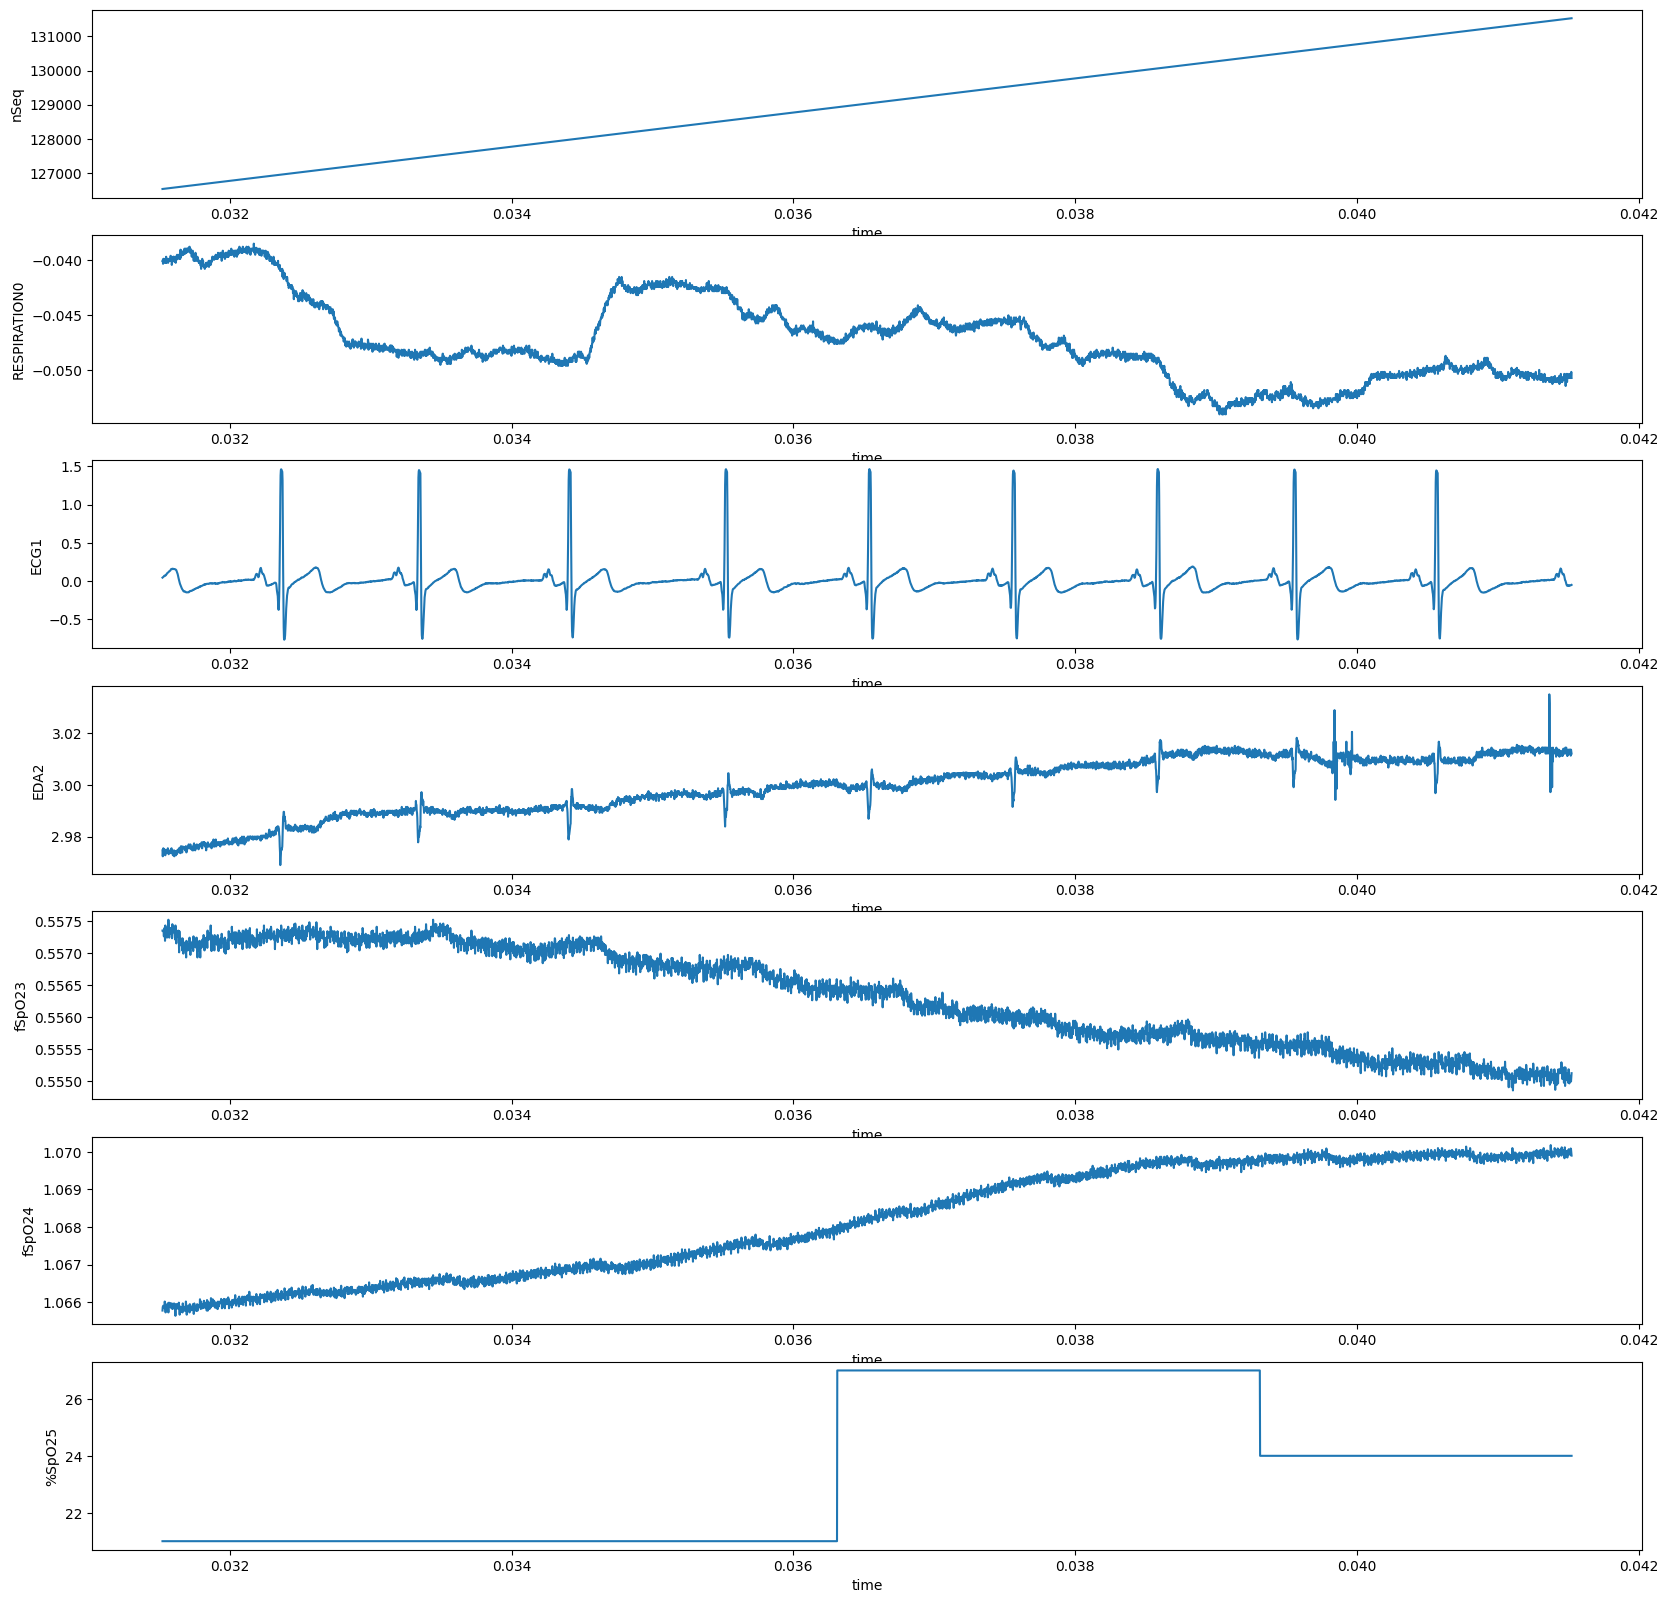

In [38]:
physio_resting_state = get_event_data('RestingState', ps_df, stim_df)
fig, ax = plt.subplots(figsize=(20,20), nrows=len(column_labels), ncols=1)

# Make this one figure with subplots
#for i, col in enumerate(['RESPIRATION0', 'fSpO21', 'fSpO22', '%SpO23']):
for i, col in enumerate(column_labels):
    

    #plt.plot(ps_df.loc[(ps_df['time'] > 1000) & (ps_df['time'] < 1015), col])
    #plt.subplot(ps_df['time'], ps_df[col], ax= ax[i])
    sns.lineplot(data=physio_resting_state[:5000], x='time', y=col, ax=ax[i])

# Linking Microphone Data to Video Data

In [39]:
mic_data = data[streams_collected.index('Microphone')]
mic_df = pd.DataFrame(mic_data['time_series'], columns=['int_array'])
mic_df['bytestring'] = mic_df['int_array'].apply(lambda x: np.array(x).tobytes())
#mic_df['time'] = (mic_data['time_stamps'] - mic_data['time_stamps'][0])/441000

mic_df['lsl_time_stamp'] = mic_data['time_stamps']
mic_df['time_delta'] = mic_df['lsl_time_stamp'].diff()

mic_df.head()

,int_array,bytestring,lsl_time_stamp,time_delta
0,5,b'\x05\x00\x00\x00\x00\x00\x00\x00',1.074255e+06,NaN
1,8,b'\x08\x00\x00\x00\x00\x00\x00\x00',1.074255e+06,0.000023
2,6,b'\x06\x00\x00\x00\x00\x00\x00\x00',1.074255e+06,0.000023
3,8,b'\x08\x00\x00\x00\x00\x00\x00\x00',1.074255e+06,0.000023
4,5,b'\x05\x00\x00\x00\x00\x00\x00\x00',1.074255e+06,0.000023


In [40]:
precision = 1e-8
fs = 44100
sum(abs(mic_df.time_delta - 1/fs) < precision) == len(mic_df) - 1


True

## checking duration of mic data

In [41]:
mic_exp = get_event_data('Experiment', mic_df, stim_df)
start = mic_exp['lsl_time_stamp'].values[0]
stop = mic_exp['lsl_time_stamp'].values[-1]
mic_dur = stop - start
mic_dur

1850.3854383274447

In [42]:
mic_story = get_event_data('StoryListening', mic_df, stim_df=stim_df)
start = mic_story['lsl_time_stamp'].values[0]
stop = mic_story['lsl_time_stamp'].values[-1]
mic_story_dur = stop - start
print(mic_story_dur)

story_start = stim_df.loc[stim_df.event == 'Onset_StoryListening', 'lsl_time_stamp'].values[0]
story_end = stim_df.loc[stim_df.event == 'Offset_StoryListening', 'lsl_time_stamp'].values[0]
story_dur = story_end - story_start
story_dur

1169.5030009546317


1184.9836457241327

In [43]:
#conversation_onset_stim = stim_df.loc[stim_df.event == 'Onset_SocialTask', 'time'].values[0]
#conversation_offset_stim = stim_df.loc[stim_df.event == 'Offset_SocialTask', 'time'].values[0]
#
# convo = mic_df.loc[(mic_df['time'] > conversation_onset_stim ) & (mic_df['time'] < conversation_offset_stim), 'int_array'].values
convo = get_event_data('Tornado', mic_df, stim_df)
convo


,int_array,bytestring,lsl_time_stamp,time_delta
35446260,0,b'\x00\x00\x00\x00\x00\x00\x00\x00',1.075059e+06,0.000023
35446261,2,b'\x02\x00\x00\x00\x00\x00\x00\x00',1.075059e+06,0.000023
35446262,0,b'\x00\x00\x00\x00\x00\x00\x00\x00',1.075059e+06,0.000023
35446263,-2,b'\xfe\xff\xff\xff\xff\xff\xff\xff',1.075059e+06,0.000023
35446264,1,b'\x01\x00\x00\x00\x00\x00\x00\x00',1.075059e+06,0.000023
...,...,...,...,...
42060145,41,b')\x00\x00\x00\x00\x00\x00\x00',1.075209e+06,0.000023
42060146,40,b'(\x00\x00\x00\x00\x00\x00\x00',1.075209e+06,0.000023
42060147,42,b'*\x00\x00\x00\x00\x00\x00\x00',1.075209e+06,0.000023
42060148,42,b'*\x00\x00\x00\x00\x00\x00\x00',1.075209e+06,0.000023


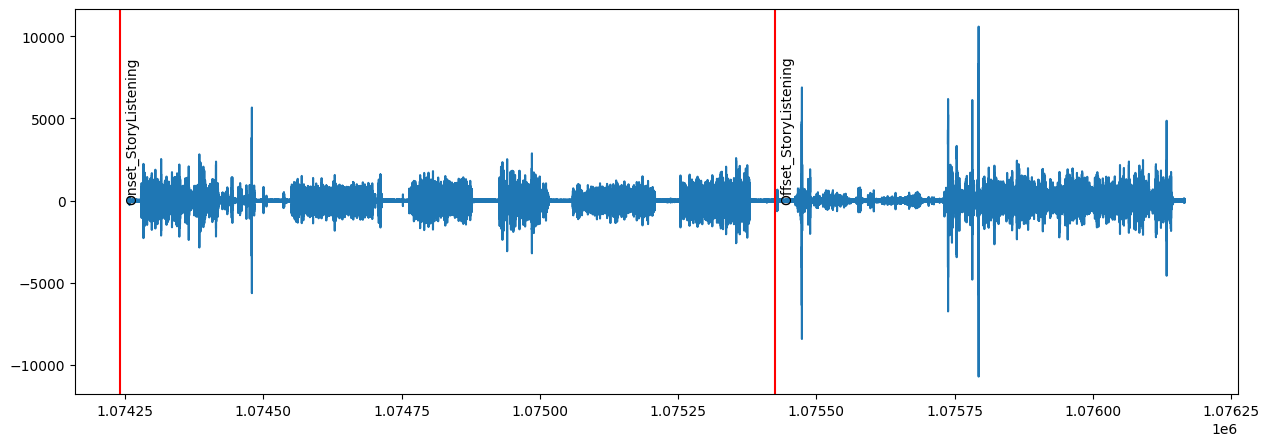

In [46]:
f, ax = plt.subplots(figsize=(15, 5))
plt.plot(mic_df.lsl_time_stamp, mic_df.int_array)
for event in evs.loc[evs.event.str.contains('StoryListening')].iterrows():
    ax.axvline(event[1]['lsl_time_stamp'], color='r')
    ax.text(event[1]['lsl_time_stamp']+10, 0, event[1]['event'], rotation=90)
        

In [ ]:
sd.play(convo.int_array.values)
sd.stop()

# Video Data
Now lets open the video frames

In [ ]:
# Identify the frames we're interested in
cam_data = data[streams_collected.index('WebcamStream')]

#cam_df = pd.DataFrame(cam['time_series'], columns=['frame'])
#cam_df['lsl_timestamps'] = cam['time_stamps']
#cam_df['time'] = cam_df['lsl_timestamps'] - cam_df['lsl_timestamps'][0]
cam_data['time_series'][0]
frame_nums = [int(i[0]) for i in cam_data['time_series']]
time_pre = [float(i[1]) for i in cam_data['time_series']]
time_evnt_ms = [float(i[2]) for i in cam_data['time_series']]
time_post = [float(i[3]) for i in cam_data['time_series']]


cam_df = pd.DataFrame({'frame_num': frame_nums, 
                    'time_pre': time_pre, 
                    'cap_time_ms': time_evnt_ms,
                    'time_post': time_post,
                    'lsl_time_stamp': cam_data['time_stamps']})



cam_df['frame_time_sec'] = (cam_df.cap_time_ms - cam_df.cap_time_ms[0])/1000
cam_df['lsl_time_sec'] = cam_df.lsl_time_stamp #- cam_df.lsl_time_stamp[0]
cam_df['time'] = (cam_df.lsl_time_stamp - cam_df.lsl_time_stamp[0])/1000

## checking duration of cam data

In [ ]:
exp_start = stim_df.loc[stim_df.event == 'Onset_Experiment', 'lsl_time_stamp'].values[0]
exp_end = stim_df.loc[stim_df.event == 'Offset_Experiment', 'lsl_time_stamp'].values[0]
exp_dur = exp_end - exp_start
print(exp_dur)

cam_exp = get_event_data('Experiment', cam_df, stim_df=stim_df)
start = cam_exp['lsl_time_stamp'].values[0]
stop = cam_exp['lsl_time_stamp'].values[-1]
cam_dur = stop - start
print(cam_dur)


2290.8275453991955
2290.448885845137


In [ ]:
#vid_convo = cam_df.loc[(cam_df['lsl_time_sec'] > conversation_onset_stim ) & (cam_df['lsl_time_sec'] < conversation_offset_stim)]
vid_convo = get_event_data('SocialTask', cam_df, stim_df)
vid_convo_frames = vid_convo['frame_num'].values

A goal here is to identify timestamps in the microphone data and their corresponding frames in the video data

In [ ]:
sd.play(convo.int_array.values, 44100)
sd.stop()


In [ ]:
# Use cv2 to read the video file and play the frames
cap = cv2.VideoCapture('C:/Users/Admin/Documents/code/MOBI2024/CUNY_FACIAL/video_files/2222_CUNY_Face_Full_Protocol.avi')
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# play the video
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        if cap.get(1) in vid_convo_frames:
            cv2.imshow('Frame', frame)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        
        cv2.imshow('Frame', frame)
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
        else:
            continue
    else:
        break


OpenCV: Couldn't read video stream from file "C:/Users/Admin/Documents/code/MOBI2024/CUNY_FACIAL/video_files/2222_CUNY_Face_Full_Protocol.avi"


In [ ]:
# Use cv2 to read the video file and play the frames
cap = cv2.VideoCapture('C:/Users/Admin/Documents/code/MOBI2024/CUNY_FACIAL/video_files/2222_CUNY_Face_Full_Protocol.avi')
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# play the video
while(cap.isOpened()):
    sd.play(convo.int_array.values, 44100)
    ret, frame = cap.read()
    if ret == True:
        if cap.get(1) in vid_convo_frames:
            cv2.imshow('Frame', frame)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        else:
            continue
    else:
        break


OpenCV: Couldn't read video stream from file "C:/Users/Admin/Documents/code/MOBI2024/CUNY_FACIAL/video_files/2222_CUNY_Face_Full_Protocol.avi"


# Eye Tracking

In [113]:
ET = data[streams_collected.index('Tobii')]
et_dat = ET['time_series']
# Get the column names
column_labels = [ET['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(ET['info']['desc'][0]['channels'][0]['channel']))]

et_df = pd.DataFrame(data=et_dat, columns=column_labels)
et_df['lsl_time_stamp'] = ET['time_stamps']
et_df['time'] = (ET['time_stamps'] - ET['time_stamps'][0])/1000
et_df.head()

,device_time_stamp,left_gaze_origin_validity,right_gaze_origin_validity,left_gaze_origin_in_user_coordinate_system_0,left_gaze_origin_in_user_coordinate_system_1,left_gaze_origin_in_user_coordinate_system_2,right_gaze_origin_in_user_coordinate_system_0,right_gaze_origin_in_user_coordinate_system_1,right_gaze_origin_in_user_coordinate_system_2,left_gaze_origin_in_trackbox_coordinate_system_0,...,left_gaze_point_on_display_area_0,left_gaze_point_on_display_area_1,right_gaze_point_on_display_area_0,right_gaze_point_on_display_area_1,left_pupil_validity,right_pupil_validity,left_pupil_diameter,right_pupil_diameter,lsl_time_stamp,time
0,1.752509e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,737627.304371,0.000000
1,1.752509e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,737627.312704,0.000008
2,1.752509e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,737627.321038,0.000017
3,1.752509e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,737627.329372,0.000025
4,1.752509e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,737627.337705,0.000033


In [ ]:
et_df.time.describe()

count    170397.000000
mean          0.716657
std           0.429142
min           0.000000
25%           0.355004
50%           0.710008
75%           1.065012
max           2.440707
Name: time, dtype: float64

In [ ]:
ps_df.time.describe()

count    1.478592e+06
mean     1.232072e+00
std      7.113380e-01
min      0.000000e+00
25%      6.160362e-01
50%      1.232072e+00
75%      1.848109e+00
max      2.464145e+00
Name: time, dtype: float64

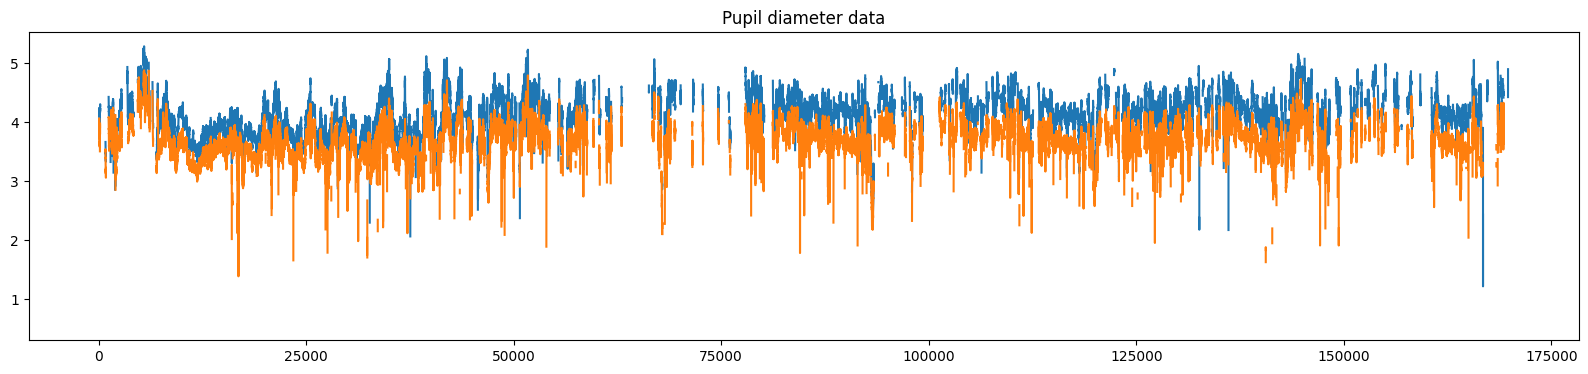

In [ ]:
# Plot left_pupil_diameter and right_pupil_diameter
plt.figure(figsize=(20, 4))
plt.plot(et_df['left_pupil_diameter'][:1300000], label='left_pupil_diameter');
plt.plot(et_df['right_pupil_diameter'][:1300000], label='right_pupil_diameter');
plt.title('Pupil diameter data');

<Axes: xlabel='x', ylabel='y'>

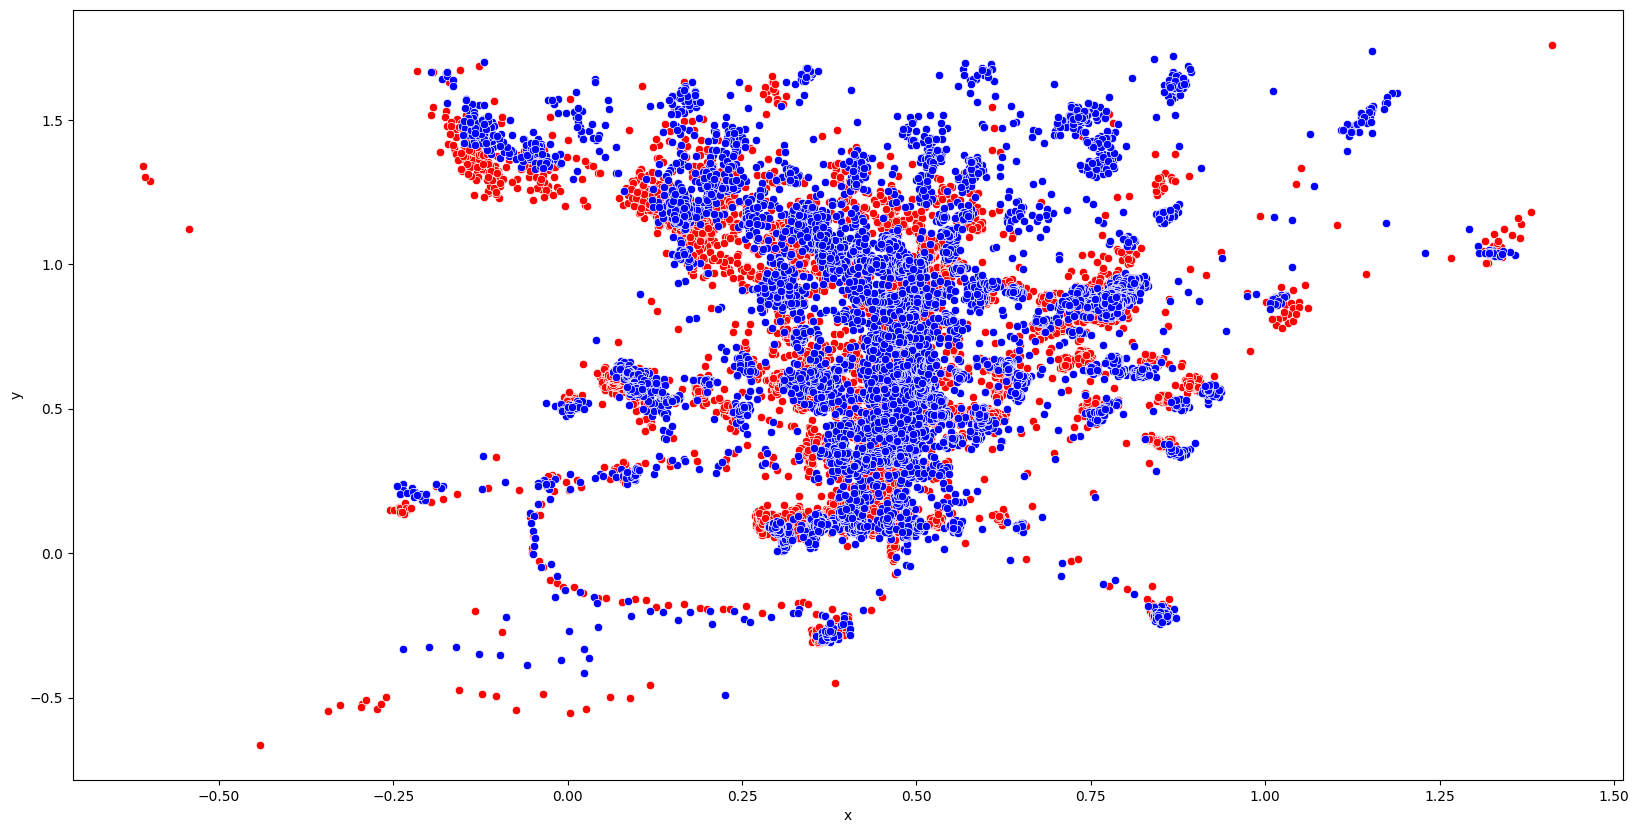

In [ ]:

evnt_of_interest = 'CampFriend'
onset = stim_df.loc[stim_df.event == 'Onset_'+ evnt_of_interest, 'time'].values[0]
offset = stim_df.loc[stim_df.event == 'Offset_'+ evnt_of_interest, 'time'].values[0]
left_x = et_df.loc[(et_df.time > onset) & (et_df.time < offset), 'left_gaze_point_on_display_area_0']
left_y = et_df.loc[(et_df.time > onset) & (et_df.time < offset), 'left_gaze_point_on_display_area_1']
left = pd.DataFrame({'x': left_x, 'y': left_y})
# Right
right_x = et_df.loc[(et_df.time > onset) & (et_df.time < offset), 'right_gaze_point_on_display_area_0']
right_y = et_df.loc[(et_df.time > onset) & (et_df.time < offset), 'right_gaze_point_on_display_area_1']
right = pd.DataFrame({'x': right_x, 'y': right_y})
fig, ax = plt.subplots( figsize=(20, 10))
sns.scatterplot(data=right, x='x', y='y', color='r')
#ax[0].set_title('Right eye')
sns.scatterplot(data=left, x='x', y='y', color='b')
#ax[1].set_title('Left eye')

In [ ]:
ET = data[streams_collected.index('Tobii')]
et_dat = ET['time_series']

In [ ]:
# Get the units associated with each eyetracking variable
ET['info']['desc'][0]#['channels'][0]['channel'][0]['unit'][0]

defaultdict(list,
            {'manufacturer': ['Tobii'],
             'channels': [defaultdict(list,
                          {'channel': [defaultdict(list,
                                        {'label': ['device_time_stamp'],
                                         'unit': ['device'],
                                         'type': ['ET']}),
                            defaultdict(list,
                                        {'label': ['left_gaze_origin_validity'],
                                         'unit': ['device'],
                                         'type': ['ET']}),
                            defaultdict(list,
                                        {'label': ['right_gaze_origin_validity'],
                                         'unit': ['device'],
                                         'type': ['ET']}),
                            defaultdict(list,
                                        {'label': ['left_gaze_origin_in_user_coordinate_system_0'],
       

# EEG

In [ ]:
eeg_dat = data[streams_collected.index('EGI NetAmp 0')]
eeg_df = pd.DataFrame(eeg_dat['time_series'])
eeg_df['lsl_time_stamp'] = eeg_dat['time_stamps']
#eeg_dat['lsl_time_stamp'] = EEG['time_stamps']

In [ ]:
cam_df

,frame_num,time_pre,cap_time_ms,time_post,lsl_time_stamp,frame_time_sec,lsl_time_sec,time
0,1,1.729194e+09,1.752603e+09,1.729194e+09,737703.231317,0.000000,737703.231317,0.000000
1,2,1.729194e+09,1.752603e+09,1.729194e+09,737703.264652,0.033333,737703.264652,0.000033
2,3,1.729194e+09,1.752603e+09,1.729194e+09,737703.297986,0.066667,737703.297986,0.000067
3,4,1.729194e+09,1.752603e+09,1.729194e+09,737703.331321,0.100000,737703.331321,0.000100
4,5,1.729194e+09,1.752603e+09,1.729194e+09,737703.364655,0.133333,737703.364655,0.000133
...,...,...,...,...,...,...,...,...
70643,70644,1.729196e+09,1.754958e+09,1.729196e+09,740058.082515,2354.866667,740058.082515,2.354851
70644,70645,1.729196e+09,1.754958e+09,1.729196e+09,740058.115849,2354.900000,740058.115849,2.354885
70645,70646,1.729196e+09,1.754958e+09,1.729196e+09,740058.149184,2354.933333,740058.149184,2.354918
70646,70647,1.729196e+09,1.754958e+09,1.729196e+09,740058.182518,2354.966667,740058.182518,2.354951


In [ ]:
eeg_exp = get_event_data('Experiment', eeg_df, stim_df=stim_df)
start = eeg_exp['lsl_time_stamp'].values[0]
stop = eeg_exp['lsl_time_stamp'].values[-1]
eeg_dur = stop - start
print(eeg_dur)

2290.8256253656


Apply Notch Filter?

In [ ]:
def apply_notch_filter(data, fs, f0, Q):
    nyquist = 0.5 * fs
    w0 = f0 / nyquist
    b, a = iirnotch(w0, Q)
    return filtfilt(b, a, data)

filtered_eeg = eeg_df.apply(lambda x: apply_notch_filter(x, 1000, 60, 30))

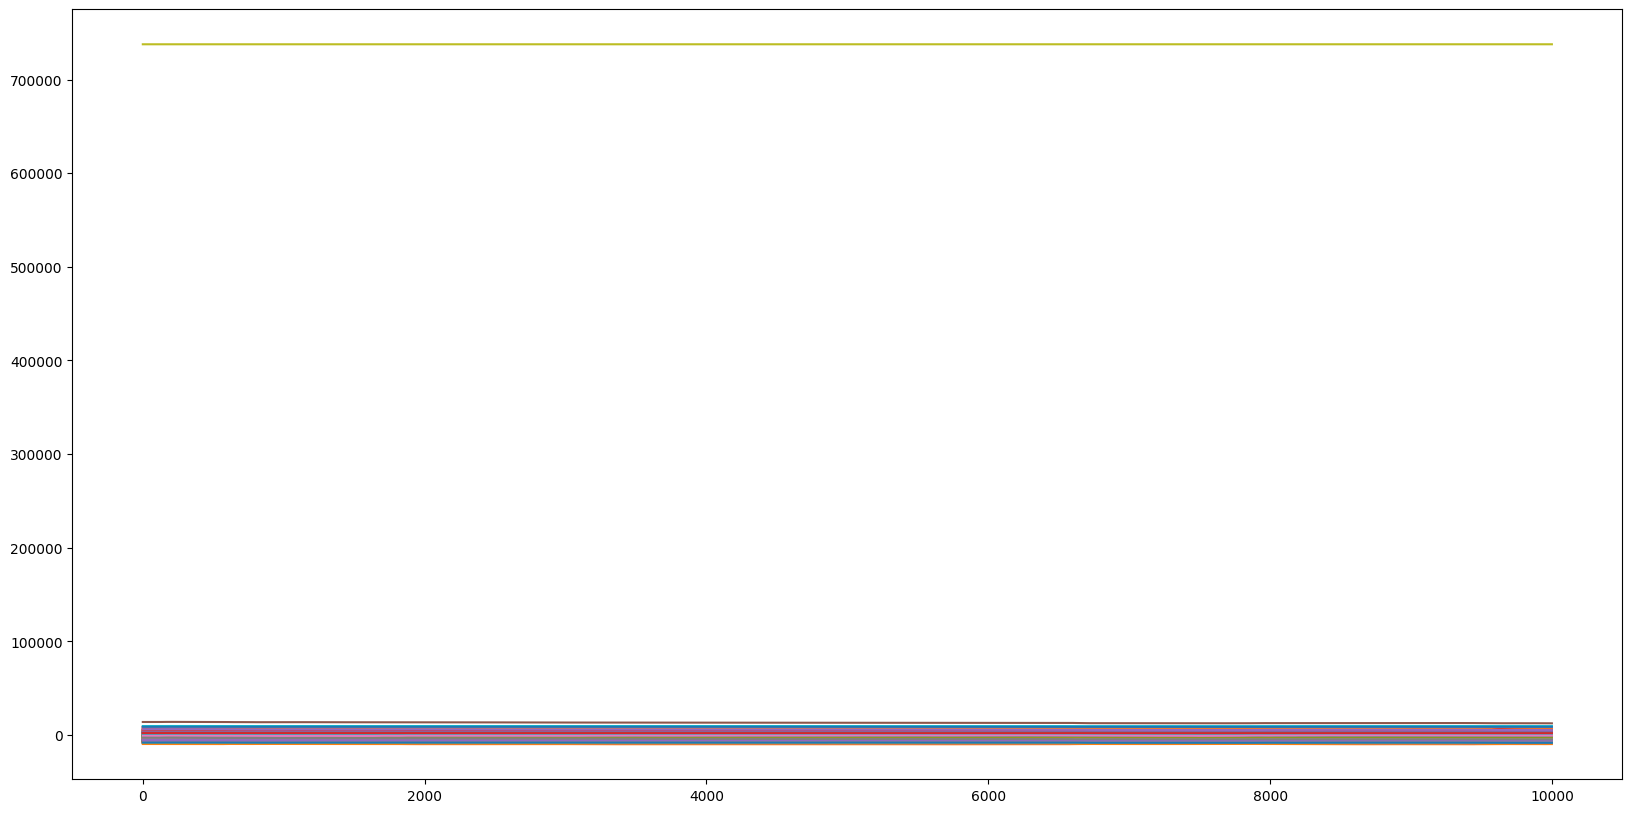

In [ ]:
# plot the EEG data
plt.figure(figsize=(20, 10))
plt.plot(filtered_eeg[:10000]);


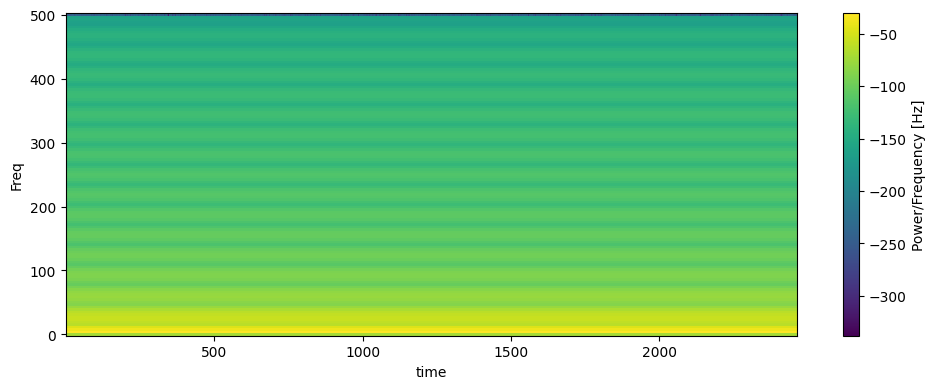

In [ ]:
rest_eeg = filtered_eeg #eeg_dat[:-1] #get_event_data('RestingState', eeg_dat)
from scipy.signal import spectrogram

plt.figure(figsize=(10, 4))

for column in rest_eeg.columns:
    f, t, Sxx = spectrogram(rest_eeg[column], fs=1000)

    plt.pcolormesh(t, f, 10 *np.log10(Sxx), shading='nearest')

plt.colorbar(label='Power/Frequency [Hz]')
plt.ylabel('Freq')
plt.xlabel('time')
plt.tight_layout()
plt.show()

/var/folders/8t/3zxw9ymj0dz7gvv5vyvt45j4wh1rnl/T/ipykernel_83229/1828837399.py:8: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t, f, 10 *np.log10(Sxx), shading='nearest')


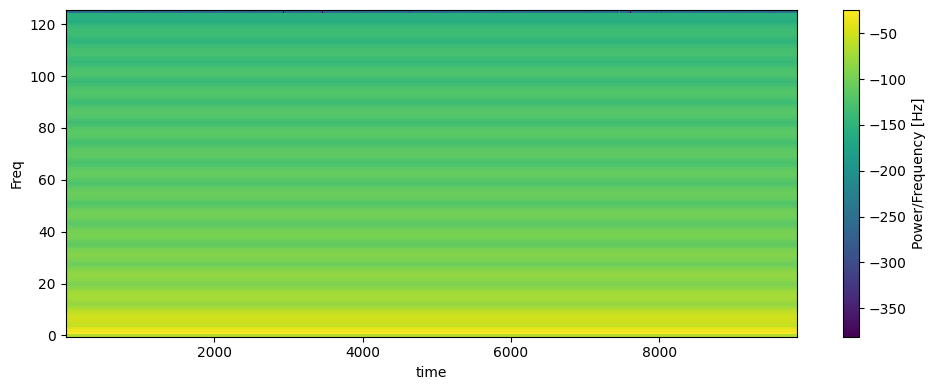

In [ ]:
from scipy.signal import spectrogram

plt.figure(figsize=(10, 4))

for column in eeg_df.columns:
    f, t, Sxx = spectrogram(eeg_df[column], fs=250)

    plt.pcolormesh(t, f, 10 *np.log10(Sxx), shading='nearest')

plt.colorbar(label='Power/Frequency [Hz]')
plt.ylabel('Freq')
plt.xlabel('time')
plt.tight_layout()
plt.show()

In [ ]:
# List of variables to include in the DataFrame
variable_names = ['exp_dur', 'et_dur', 'ps_dur', 'cam_dur', 'eeg_dur', 'mic_dur', 'mic_story_dur', 'story_dur',]

# Create a dictionary with variable names and values
variables = {name: globals()[name] for name in variable_names}

# Convert the dictionary to a pandas DataFrame
durations_df = pd.DataFrame(list(variables.items()), columns=['Name', 'Value'])
durations_df.sort_values(by='Value', inplace=True)
durations_df

,Name,Value
1,et_dur,1335.187620
4,mic_story_dur,1337.072034
5,story_dur,1372.428385
7,mic_dur,1943.088336
3,cam_dur,2290.448886
2,ps_dur,2290.825323
6,eeg_dur,2290.825625
0,exp_dur,2290.827545


In [ ]:
for i in durations_df.iterrows():
    if i[1]['Value'] < (exp_dur - 10): # 10 second margin
        print(i[1]['Name'] + ' is shorter than expected')


et_dur is less than 10 seconds shorter than the experiment duration
mic_story_dur is less than 10 seconds shorter than the experiment duration
story_dur is less than 10 seconds shorter than the experiment duration
mic_dur is less than 10 seconds shorter than the experiment duration


## Durations for each Experiment Part

In [ ]:
streams = ['et', 'ps', 'cam', 'eeg', 'mic']

def get_durations(ExperimentPart):
    df = pd.DataFrame(columns = ['stream', 'duration'])

    # make df
    for i, stream in enumerate(list):
        event_data = get_event_data(ExperimentPart, globals()[stream+'_df'], stim_df)
        # print if no data
        if event_data.empty:
            df.loc[i] = [stream,0]
            print(stream + ' has no ' + ExperimentPart + ' data') 
            continue
        start = event_data['lsl_time_stamp'].values[0]
        stop = event_data['lsl_time_stamp'].values[-1]
        dur = stop - start

        df.loc[i] = [stream, dur]

    # find expected
    exp_start = stim_df.loc[stim_df.event == 'Onset_'+ExperimentPart, 'lsl_time_stamp'].values[0]
    exp_end = stim_df.loc[stim_df.event == 'Offset_'+ExperimentPart, 'lsl_time_stamp'].values[0]
    exp_dur = exp_end - exp_start
    df.loc[len(df)] = ['expected', exp_dur]

    # print which are short
    for i in df.iterrows():
        if i[1]['duration'] == 0:
            continue
        if i[1]['duration'] < (exp_dur - 10): # 10 second margin
            print(i[1]['stream'] + ' is shorter than expected for ' + ExperimentPart + ' by ' + str(round(exp_dur - i[1]['duration'], 2)) + ' seconds???')
    
    df.sort_values(by='duration', inplace=True)
    return df
    

In [175]:
get_durations('Experiment')

et is shorter than expected for Experiment by 955.64 milliseconds???
mic is shorter than expected for Experiment by 347.74 milliseconds???


,stream,duration
0,et,1335.187620
4,mic,1943.088336
2,cam,2290.448886
1,ps,2290.825323
3,eeg,2290.825625
5,expected,2290.827545


In [165]:
get_durations('RestingState')

mic has no RestingState data


,stream,dur
4,mic,0.000000
2,cam,299.977435
0,et,299.985325
3,eeg,299.998689
1,ps,299.998871
5,expected,299.999819


In [176]:
get_durations('StoryListening')

et is shorter than expected for StoryListening by 349.62 milliseconds???
mic is shorter than expected for StoryListening by 35.36 milliseconds???


,stream,duration
0,et,1022.810202
4,mic,1337.072034
2,cam,1372.382597
1,ps,1372.426673
3,eeg,1372.427902
5,expected,1372.428385


In [177]:
get_durations('SocialTask')

et has no SocialTask data


,stream,duration
0,et,0.000000
2,cam,300.444118
1,ps,300.492170
3,eeg,300.493707
4,mic,300.494701
5,expected,300.494714


## Response durations

In [197]:
story_onsets
story_offsets = [x+1 for x in story_onsets]

In [ ]:
[print(events[onset], events[offset]) for onset, offset in zip(story_onsets, story_offsets)]


Onset_CampFriend Offset_CampFriend
Onset_FrogDissection Offset_FrogDissection
Onset_DanceContest Offset_DanceContest
Onset_ZoomClass Offset_ZoomClass
Onset_Tornado Offset_Tornado
Onset_BirthdayParty Offset_BirthdayParty


[None, None, None, None, None, None]

In [217]:
for i, row in stories_df.iterrows():
    if row['trigger'] in story_offsets:
        print(row['trigger'])   

71
61
31
21
41
51


In [210]:
for onset, offset in zip(story_onsets, story_offsets):
    print(events[onset], events[offset])
    print(get_secs_between_triggers(offset, onset, stim_df))


Onset_CampFriend Offset_CampFriend
0.15285571379051555
Onset_FrogDissection Offset_FrogDissection
0.12436584838188713
Onset_DanceContest Offset_DanceContest
0.13833377625443966
Onset_ZoomClass Offset_ZoomClass
0.09837693251878954
Onset_Tornado Offset_Tornado
0.16323988105589526
Onset_BirthdayParty Offset_BirthdayParty
0.1602316316994839


In [ ]:
durations = pd.DataFrame({
    'trigger':story_onsets,
    'story':[events[x] for x in story_onsets],
    'lsl_duration': [get_secs_between_triggers(x+1, x, stim_df) for x in story_onsets],
    # 'audiofile_duration': [wave.open(x).getnframes()/wave.open(x).getframerate() for x in audio_recordings] #duration of audio file is number of frames divided by the frame rate.
})


In [216]:
stories_df = stim_df.loc[stim_df.event.str.contains('Onset|Offset')]
stories_df

,trigger,event,lsl_time_stamp,time
0,200,Onset_Experiment,737702.874688,0.000000
2,10,Onset_RestingState,737715.257669,0.012383
4,11,Offset_RestingState,738015.257488,0.312383
6,500,Onset_StoryListening,738015.257539,0.312383
8,100,Onset_10second_rest,738106.853110,0.403978
...,...,...,...,...
249,400,Onset_impedanceCheck,739387.685944,1.684811
251,401,Offset_impedanceCheck,739675.518597,1.972644
253,80,Onset_SocialTask,739688.204254,1.985330
255,81,Offset_SocialTask,739988.698968,2.285824


In [196]:
stim_df[(stim_df.index >= 50) & (stim_df.index <= 100) & 
                      (stim_df["event"].str.contains("Onset|Offset"))]

,trigger,event,lsl_time_stamp,time
50,60,Onset_Tornado,738408.039893,0.705165
52,61,Offset_Tornado,738571.279774,0.868405
54,300,Onset_subjectInput,738580.385929,0.877511
56,301,Offset_subjectInput,738586.636600,0.883762
59,300,Onset_subjectInput,738586.648856,0.883774
61,301,Offset_subjectInput,738592.303519,0.889429
64,300,Onset_subjectInput,738592.316241,0.889442
66,301,Offset_subjectInput,738598.802872,0.895928
69,300,Onset_subjectInput,738598.835490,0.895961
71,301,Offset_subjectInput,738605.286921,0.902412
